In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score,
                            recall_score, f1_score)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Data Exploration and Preprocessing (unchanged)
def load_and_explore_data(filepath):
    df = pd.read_csv('/content/Alphabets_data.csv')

    print("=== Dataset Overview ===")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())

    print("\n=== Data Information ===")
    print(df.info())

    print("\n=== Class Distribution ===")
    print(df['letter'].value_counts())

    print("\n=== Descriptive Statistics ===")
    print(df.describe())

    # Check for missing values
    print("\n=== Missing Values ===")
    print(df.isnull().sum())

    return df

# Data Preparation with sampling for faster tuning
def prepare_data(df, sample_size=None):
    # Separate features and target
    X = df.drop('letter', axis=1)
    y = df['letter']

    # Encode target labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Sample data for faster tuning if requested
    if sample_size and sample_size < len(X_train):
        X_train, y_train = resample(X_train, y_train,
                                  n_samples=sample_size,
                                  random_state=42,
                                  stratify=y_train)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, le

# Base Model Implementation with early stopping
def build_base_model(X_train, y_train, X_test, y_test):
    print("\n=== Building Base Model ===")
    base_model = MLPClassifier(
        hidden_layer_sizes=(100,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=128,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.2,
        random_state=42,
        tol=1e-4
    )

    base_model.fit(X_train, y_train)

    # Evaluate on train and test sets
    y_train_pred = base_model.predict(X_train)
    y_test_pred = base_model.predict(X_test)

    print("\nBase Model Training Performance:")
    print(classification_report(y_train, y_train_pred))

    print("\nBase Model Test Performance:")
    print(classification_report(y_test, y_test_pred))

    return base_model

# Optimized Hyperparameter Tuning with gridSearchCV
def tune_hyperparameters(X_train, y_train):
    print("\n=== Optimized Hyperparameter Tuning with GridSearchCV ===")

    # Create pipeline with scaler and classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(max_iter=150, early_stopping=True, validation_fraction=0.2, random_state=42, tol=1e-4))
    ])

    # Carefully selected parameter grid to balance search space and execution time
    param_grid = {
        'mlp__hidden_layer_sizes': [(100,), (150,), (100, 50)],
        'mlp__activation': ['relu', 'tanh'],
        'mlp__alpha': [0.0001, 0.0005],
        'mlp__learning_rate': ['adaptive'],
        'mlp__learning_rate_init': [0.001, 0.01],
        'mlp__batch_size': [128]
    }

    # Set up stratified k-fold cross-validation with reduced splits
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # Initialize GridSearchCV with parallel processing
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )

     # Fit the grid search
    grid_search.fit(X_train, y_train)

    print("\nBest parameters found:")
    print(grid_search.best_params_)

    print("\nBest cross-validation score:")
    print(grid_search.best_score_)

    return grid_search.best_estimator_

# Model Evaluation (unchanged)
def evaluate_model(model, X_train, y_train, X_test, y_test, le):
    print("\n=== Final Model Evaluation ===")

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Classification reports
    print("\nTraining Performance:")
    print(classification_report(y_train, y_train_pred, target_names=le.classes_))

    print("\nTest Performance:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }

    return metrics

# Comparison of Models
def compare_models(base_model, tuned_model, X_test, y_test):
    print("\n=== Model Comparison ===")

    # Base model performance
    base_pred = base_model.predict(X_test)
    base_acc = accuracy_score(y_test, base_pred)

    # Tuned model performance
    tuned_pred = tuned_model.predict(X_test)
    tuned_acc = accuracy_score(y_test, tuned_pred)

    print(f"Base Model Accuracy: {base_acc:.4f}")
    print(f"Tuned Model Accuracy: {tuned_acc:.4f}")
    print(f"Improvement: {(tuned_acc - base_acc)*100:.2f}%")

    # Plot comparison
    plt.figure(figsize=(8, 6))
    plt.bar(['Base Model', 'Tuned Model'], [base_acc, tuned_acc])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()


=== Dataset Overview ===
Shape: (20000, 17)

First 5 rows:
  letter  xbox  ybox  width  height  onpix  xbar  ybar  x2bar  y2bar  xybar  \
0      T     2     8      3       5      1     8    13      0      6      6   
1      I     5    12      3       7      2    10     5      5      4     13   
2      D     4    11      6       8      6    10     6      2      6     10   
3      N     7    11      6       6      3     5     9      4      6      4   
4      G     2     1      3       1      1     8     6      6      6      6   

   x2ybar  xy2bar  xedge  xedgey  yedge  yedgex  
0      10       8      0       8      0       8  
1       3       9      2       8      4      10  
2       3       7      3       7      3       9  
3       4      10      6      10      2       8  
4       5       9      1       7      5      10  

=== Data Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dt

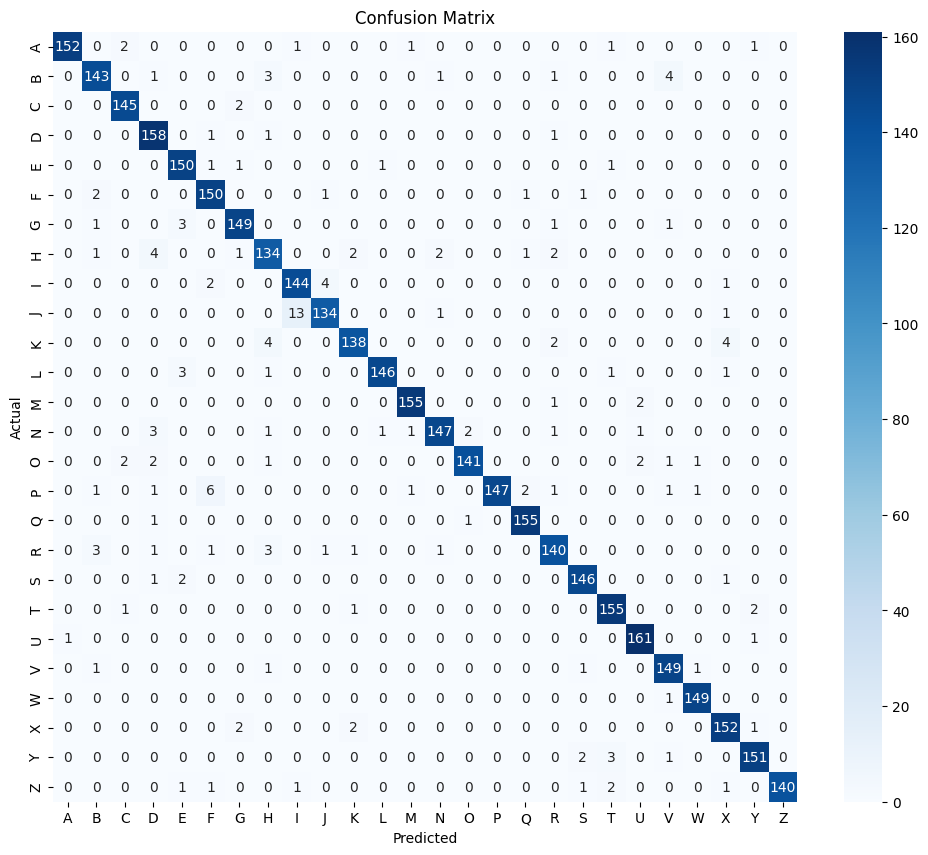


=== Model Comparison ===
Base Model Accuracy: 0.9480
Tuned Model Accuracy: 0.9577
Improvement: 0.98%


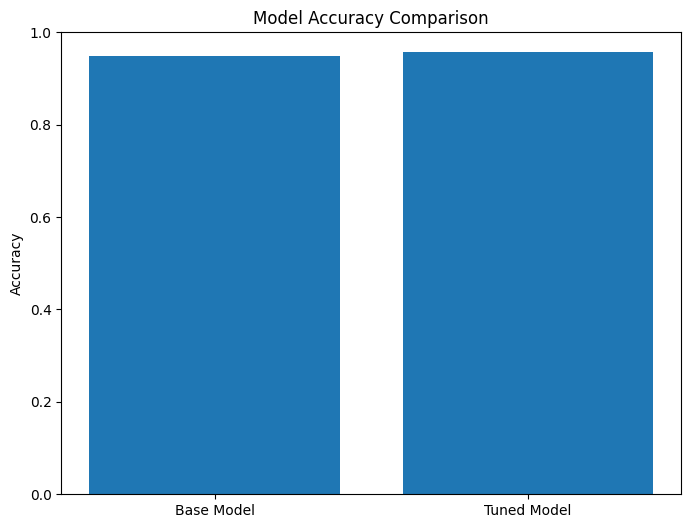


=== Final Metrics ===
Accuracy: 0.9577
Precision: 0.9584
Recall: 0.9577
F1: 0.9578


In [61]:
# Main execution with optimizations
def main():
    # Step 1: Load and explore data
    df = load_and_explore_data('Alphabets_data.csv')

    # Step 2: Prepare data with sampling for faster tuning
    # Use full data for final evaluation, sample for tuning
    X_train_full, X_test, y_train_full, y_test, le = prepare_data(df)
    X_train_tune, _, y_train_tune, _,_ = prepare_data(df, sample_size=2000)  # Sample for tuning

    # Step 3: Build and evaluate base model
    base_model = build_base_model(X_train_full, y_train_full, X_test, y_test)

    # Step 4: Hyperparameter tuning on sampled data
    print("\nTuning on sampled data for faster execution...")
    tuned_model = tune_hyperparameters(X_train_tune, y_train_tune)

    # Retrain best model on full data
    print("\nRetraining best model on full data...")
    tuned_model.fit(X_train_full, y_train_full)

    # Step 5: Evaluate tuned model
    metrics = evaluate_model(tuned_model, X_train_full, y_train_full, X_test, y_test, le)

    # Step 6: Compare models
    compare_models(base_model, tuned_model, X_test, y_test)

    # Print final metrics
    print("\n=== Final Metrics ===")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == "__main__":
    main()